## Import libraries

In [1]:
! pip install impyute

In [2]:
import gc
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
from impyute.imputation.cs import mice
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Add
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.layers import Embedding, Conv1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.metrics import MeanSquaredLogarithmicError

np.random.seed(42)
tf.random.set_seed(42)

## Load source datasets

In [3]:
train = pd.read_csv("../input/mh-dare-in-reality/train.csv")
print(f"train: {train.shape}")
train.head()

train: (10276, 25)


,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,92,0,NaN,05:43.3,0,35.427,0,...,05:43.3,00:35.4,00:43.3,SB,05:14.7,NaN,JR,NaN,Location 2,Free Practice 2
1,10,1,2,87,2,NaN,25.674,2,33.399,2,...,00:25.7,00:33.4,00:41.9,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
2,10,1,3,73,0,B,28.129,0,34.091,0,...,00:28.1,00:34.1,00:57.2,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
3,11,1,1,73,0,NaN,01:05.0,0,38.416,0,...,01:05.0,00:38.4,00:56.8,LGRA,00:33.0,NaN,AD,NaN,Location 2,Free Practice 2
4,11,1,2,73,0,NaN,28.013,0,36.743,0,...,00:28.0,00:36.7,00:44.7,LGRA,NaN,NaN,AD,NaN,Location 2,Free Practice 2


In [4]:
train_weather = pd.read_csv("../input/mh-dare-in-reality/train_weather.csv")
print(f"train_weather: {train_weather.shape}")
train_weather.head()

train_weather: (914, 11)


,TIME_UTC_SECONDS,TIME_UTC_STR,AIR_TEMP,TRACK_TEMP,HUMIDITY,PRESSURE,WIND_SPEED,WIND_DIRECTION,RAIN,LOCATION,EVENT
0,1618042506,10/04/21 8:15,15,18.4,60,1018.05,2.12187,165,-1,Location 2,Free Practice 2
1,1618042567,10/04/21 8:16,15.0556,18.4,60,1018.12,1.06093,177,-1,Location 2,Free Practice 2
2,1618042632,10/04/21 8:17,15.0556,18.5,60,1018.12,2.12187,157,-1,Location 2,Free Practice 2
3,1618042697,10/04/21 8:18,15.0556,18.5,60,1018.08,2.12187,163,-1,Location 2,Free Practice 2
4,1618042762,10/04/21 8:19,15.1111,18.5,60,1018.15,3.1828,149,-1,Location 2,Free Practice 2


In [5]:
test = pd.read_csv("../input/mh-dare-in-reality/test.csv")
print(f"test: {test.shape}")
test.head()

test: (420, 25)


,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,NaN,0,NaN,01:10.2,0,35.433,0,...,01:10.2,00:35.4,00:30.7,SB,00:47.0,1.0,JR,NaN,Location 7,Qualifying Group 1
1,10,1,2,NaN,0,NaN,27.667,0,33.68,0,...,00:27.7,00:33.7,00:37.8,SB,NaN,1.0,JR,250.0,Location 7,Qualifying Group 1
2,10,1,3,NaN,2,NaN,24.688,2,29.309,2,...,00:24.7,00:29.3,00:27.1,SB,NaN,1.0,JR,250.0,Location 7,Qualifying Group 1
3,13,1,1,NaN,0,NaN,01:09.1,0,35.705,0,...,01:09.1,00:35.7,00:30.5,ACO,00:44.7,1.0,DSo,NaN,Location 7,Qualifying Group 1
4,13,1,2,NaN,0,NaN,28.401,0,33.693,0,...,00:28.4,00:33.7,00:36.0,ACO,NaN,1.0,DSo,250.0,Location 7,Qualifying Group 1


In [6]:
test_weather = pd.read_csv("../input/mh-dare-in-reality/test_weather.csv").rename(columns={'EVENTS':'EVENT'})
print(f"test_weather: {test_weather.shape}")
test_weather.head()

test_weather: (167, 11)


,TIME_UTC_SECONDS,TIME_UTC_STR,AIR_TEMP,TRACK_TEMP,HUMIDITY,PRESSURE,WIND_SPEED,WIND_DIRECTION,RAIN,LOCATION,EVENT
0,1628920823,14/08/21 6:00,"20,35","25,4","63,94","1016,46","1,18",203,0,Location 8,Free Practice 2
1,1628920883,14/08/21 6:01,"20,33","25,4","63,96","1016,48","10,83",204,0,Location 8,Free Practice 2
2,1628920943,14/08/21 6:02,"20,25","25,4","64,04","1016,48","12,53",201,0,Location 8,Free Practice 2
3,1628921003,14/08/21 6:03,"20,24","25,3","64,22","1016,49","2,28",198,0,Location 8,Free Practice 2
4,1628921063,14/08/21 6:04,"20,27","25,1","64,14","1016,5","11,28",204,0,Location 8,Free Practice 2


In [7]:
train_weather = train_weather.append(test_weather, ignore_index=True)
print(f"train_weather: {train_weather.shape}")
train_weather.head()

train_weather: (1081, 11)


,TIME_UTC_SECONDS,TIME_UTC_STR,AIR_TEMP,TRACK_TEMP,HUMIDITY,PRESSURE,WIND_SPEED,WIND_DIRECTION,RAIN,LOCATION,EVENT
0,1618042506,10/04/21 8:15,15,18.4,60,1018.05,2.12187,165,-1,Location 2,Free Practice 2
1,1618042567,10/04/21 8:16,15.0556,18.4,60,1018.12,1.06093,177,-1,Location 2,Free Practice 2
2,1618042632,10/04/21 8:17,15.0556,18.5,60,1018.12,2.12187,157,-1,Location 2,Free Practice 2
3,1618042697,10/04/21 8:18,15.0556,18.5,60,1018.08,2.12187,163,-1,Location 2,Free Practice 2
4,1618042762,10/04/21 8:19,15.1111,18.5,60,1018.15,3.1828,149,-1,Location 2,Free Practice 2


## EDA + Data Preprocessing

In [8]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10276 entries, 0 to 10275
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NUMBER                        10276 non-null  int64  
 1    DRIVER_NUMBER                10276 non-null  int64  
 2    LAP_NUMBER                   10276 non-null  int64  
 3   LAP_TIME                      10276 non-null  int64  
 4    LAP_IMPROVEMENT              10276 non-null  int64  
 5    CROSSING_FINISH_LINE_IN_PIT  1234 non-null   object 
 6    S1                           10272 non-null  object 
 7    S1_IMPROVEMENT               10276 non-null  int64  
 8    S2                           10268 non-null  object 
 9    S2_IMPROVEMENT               10276 non-null  int64  
 10   S3                           10242 non-null  object 
 11   S3_IMPROVEMENT               10276 non-null  int64  
 12   KPH                          10246 non-null  float64
 13   

In [9]:
train_weather.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TIME_UTC_SECONDS  1081 non-null   int64 
 1   TIME_UTC_STR      1081 non-null   object
 2   AIR_TEMP          1081 non-null   object
 3   TRACK_TEMP        1081 non-null   object
 4   HUMIDITY          1081 non-null   object
 5   PRESSURE          1081 non-null   object
 6   WIND_SPEED        1081 non-null   object
 7   WIND_DIRECTION    1081 non-null   int64 
 8   RAIN              1081 non-null   object
 9   LOCATION          1081 non-null   object
 10  EVENT             1081 non-null   object
dtypes: int64(2), object(9)
memory usage: 93.0+ KB


### Examine target

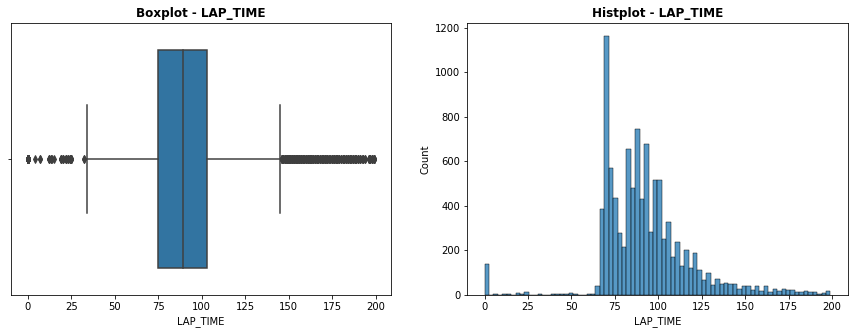

In [10]:
col = 'LAP_TIME'
x1 = train[col]

_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');

### Feature-wise EDA

#### NUMBER

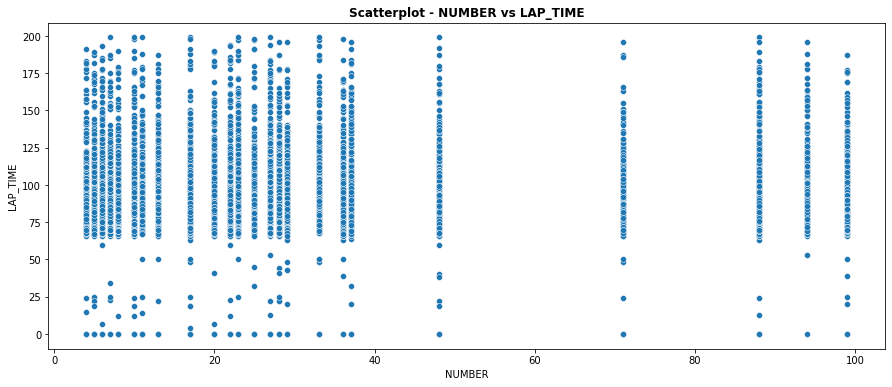

In [11]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='NUMBER', y='LAP_TIME', data=train);
plt.title("Scatterplot - NUMBER vs LAP_TIME", fontweight='bold');

#### LAP_NUMBER

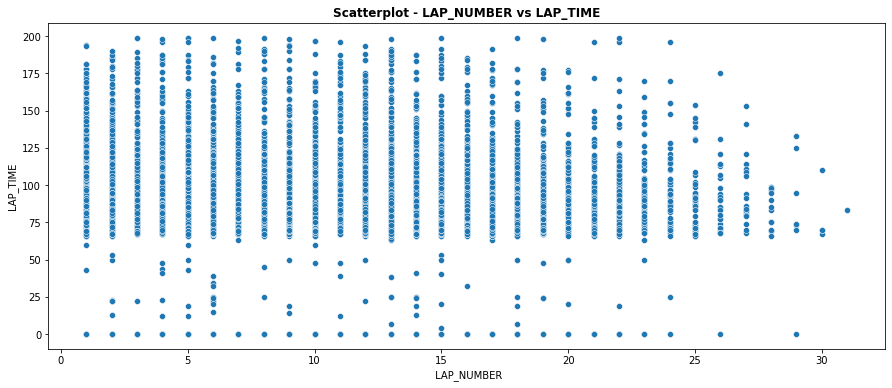

In [12]:
plt.figure(figsize=(15,6))
sns.scatterplot(x=' LAP_NUMBER', y='LAP_TIME', data=train);
plt.title("Scatterplot - LAP_NUMBER vs LAP_TIME", fontweight='bold');

#### LAP_IMPROVEMENT

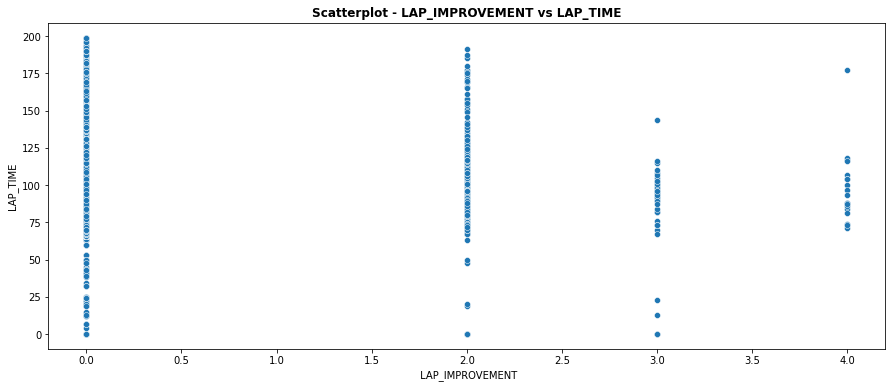

In [13]:
plt.figure(figsize=(15,6))
sns.scatterplot(x=' LAP_IMPROVEMENT', y='LAP_TIME', data=train);
plt.title("Scatterplot - LAP_IMPROVEMENT vs LAP_TIME", fontweight='bold');

#### CROSSING_FINISH_LINE_IN_PIT

In [14]:
train[' CROSSING_FINISH_LINE_IN_PIT'].fillna('A', inplace=True)
test[' CROSSING_FINISH_LINE_IN_PIT'].fillna('A', inplace=True)

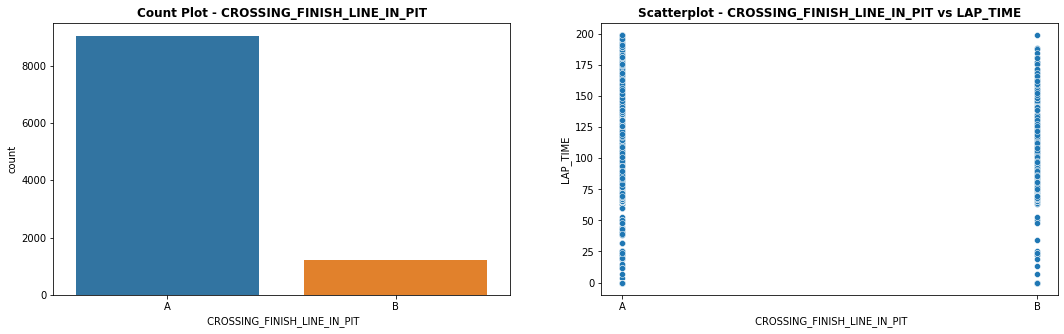

In [15]:
_, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.countplot(x=' CROSSING_FINISH_LINE_IN_PIT', data=train, ax=ax[0])
sns.scatterplot(x=' CROSSING_FINISH_LINE_IN_PIT', y='LAP_TIME', data=train, ax=ax[1])
ax[0].set_title('Count Plot - CROSSING_FINISH_LINE_IN_PIT', fontweight='bold')
ax[1].set_title('Scatterplot - CROSSING_FINISH_LINE_IN_PIT vs LAP_TIME', fontweight='bold');

In [16]:
train[' CROSSING_FINISH_LINE_IN_PIT'] = train[' CROSSING_FINISH_LINE_IN_PIT'].apply(lambda x: 1 if x=='A' else 0)
test[' CROSSING_FINISH_LINE_IN_PIT'] = test[' CROSSING_FINISH_LINE_IN_PIT'].apply(lambda x: 1 if x=='A' else 0)

#### S1/S2/S3

In [17]:
def seconder(x):
    mins = float(x.split(':')[0])
    secs = float(x.split(':')[1].split('.')[0])
    
    if len(x.split(':')[1].split('.')) < 2:
        millis = 0
    else:
        millis = float(x.split(':')[1].split('.')[1])
    
    td = timedelta(minutes=mins, seconds=secs, milliseconds=millis)
    return td.total_seconds()

In [18]:
train[' S1'] = train[' S1'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x) if ':' in x else x)
test[' S1'] = test[' S1'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x) if ':' in x else x)
train[' S1'] = train[' S1'].astype('float')
test[' S1'] = test[' S1'].astype('float')

train[' S2'] = train[' S2'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x) if ':' in x else x)
test[' S2'] = test[' S2'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x) if ':' in x else x)
train[' S2'] = train[' S2'].astype('float')
test[' S2'] = test[' S2'].astype('float')

train[' S3'] = train[' S3'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x) if ':' in x else x)
test[' S3'] = test[' S3'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x) if ':' in x else x)
train[' S3'] = train[' S3'].astype('float')
test[' S3'] = test[' S3'].astype('float')

train.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,92,0,1,343.003,0,35.427,0,...,05:43.3,00:35.4,00:43.3,SB,05:14.7,NaN,JR,NaN,Location 2,Free Practice 2
1,10,1,2,87,2,1,25.674,2,33.399,2,...,00:25.7,00:33.4,00:41.9,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
2,10,1,3,73,0,0,28.129,0,34.091,0,...,00:28.1,00:34.1,00:57.2,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
3,11,1,1,73,0,1,65.000,0,38.416,0,...,01:05.0,00:38.4,00:56.8,LGRA,00:33.0,NaN,AD,NaN,Location 2,Free Practice 2
4,11,1,2,73,0,1,28.013,0,36.743,0,...,00:28.0,00:36.7,00:44.7,LGRA,NaN,NaN,AD,NaN,Location 2,Free Practice 2


In [19]:
'''
s1_fill = train[' S1'].median()
s2_fill = train[' S2'].median()
s3_fill = train[' S3'].median()

train[' S1'].fillna(s1_fill, inplace=True)
train[' S2'].fillna(s2_fill, inplace=True)
train[' S3'].fillna(s3_fill, inplace=True)

test[' S1'].fillna(s1_fill, inplace=True)
test[' S2'].fillna(s2_fill, inplace=True)
test[' S3'].fillna(s3_fill, inplace=True)
'''

"\ns1_fill = train[' S1'].median()\ns2_fill = train[' S2'].median()\ns3_fill = train[' S3'].median()\n\ntrain[' S1'].fillna(s1_fill, inplace=True)\ntrain[' S2'].fillna(s2_fill, inplace=True)\ntrain[' S3'].fillna(s3_fill, inplace=True)\n\ntest[' S1'].fillna(s1_fill, inplace=True)\ntest[' S2'].fillna(s2_fill, inplace=True)\ntest[' S3'].fillna(s3_fill, inplace=True)\n"

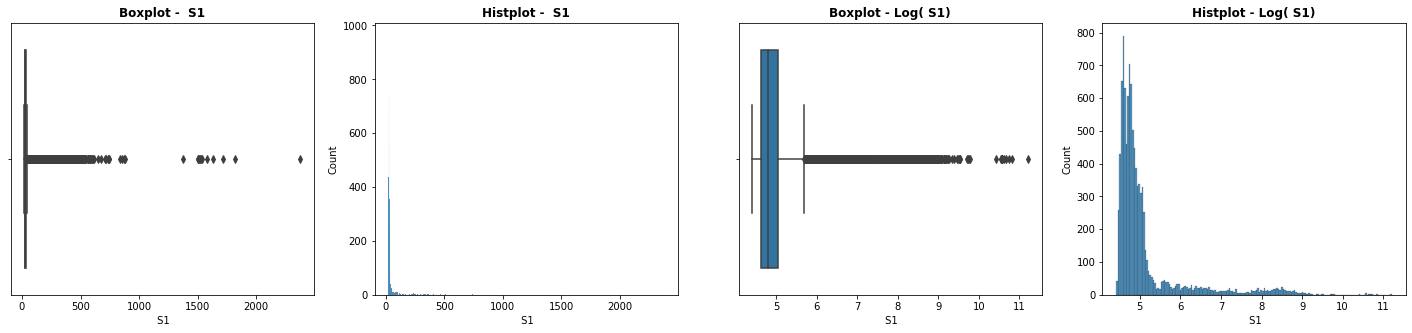

In [20]:
col = ' S1'
x1 = train[col]
x2 = np.log2(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

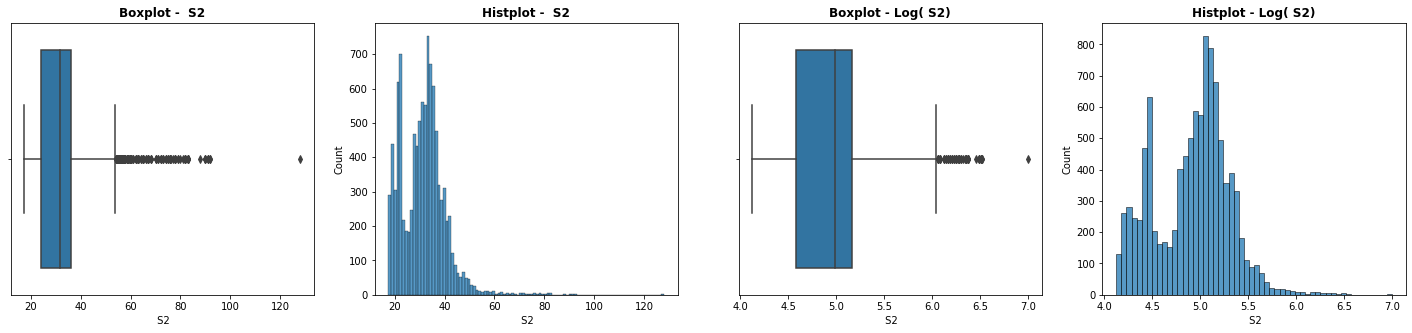

In [21]:
col = ' S2'
x1 = train[col]
x2 = np.log2(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

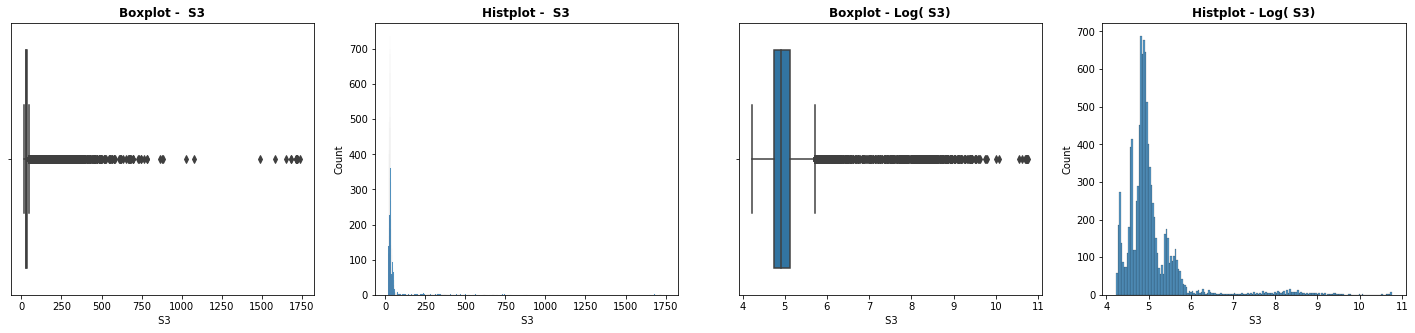

In [22]:
col = ' S3'
x1 = train[col]
x2 = np.log2(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

In [23]:
'''
train[' S1'] = np.log2(train[' S1'])
test[' S1'] = np.log2(test[' S1'])

train[' S2'] = np.log2(train[' S2'])
test[' S2'] = np.log2(test[' S2'])

train[' S3'] = np.log2(train[' S3'])
test[' S3'] = np.log2(test[' S3'])
'''

"\ntrain[' S1'] = np.log2(train[' S1'])\ntest[' S1'] = np.log2(test[' S1'])\n\ntrain[' S2'] = np.log2(train[' S2'])\ntest[' S2'] = np.log2(test[' S2'])\n\ntrain[' S3'] = np.log2(train[' S3'])\ntest[' S3'] = np.log2(test[' S3'])\n"

####  KPH

In [24]:
'''
kph_fill = train[' KPH'].median()
train[' KPH'].fillna(kph_fill, inplace=True)
test[' KPH'].fillna(kph_fill, inplace=True)
'''

"\nkph_fill = train[' KPH'].median()\ntrain[' KPH'].fillna(kph_fill, inplace=True)\ntest[' KPH'].fillna(kph_fill, inplace=True)\n"

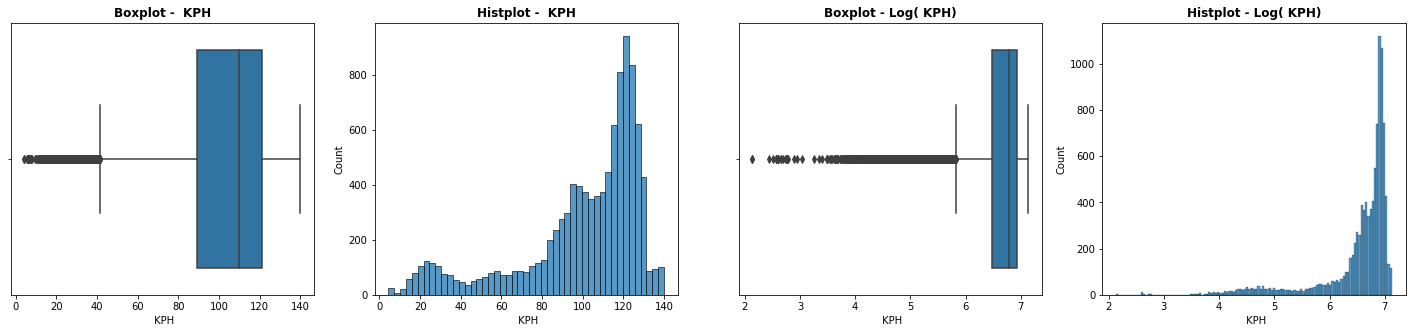

In [25]:
col = ' KPH'
x1 = train[col]
x2 = np.log2(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

#### ELAPSED

In [26]:
train[' ELAPSED'] = train[' ELAPSED'].map(seconder)
test[' ELAPSED'] = test[' ELAPSED'].map(seconder)
train[' ELAPSED'] = train[' ELAPSED'].astype('float')
test[' ELAPSED'] = test[' ELAPSED'].astype('float')

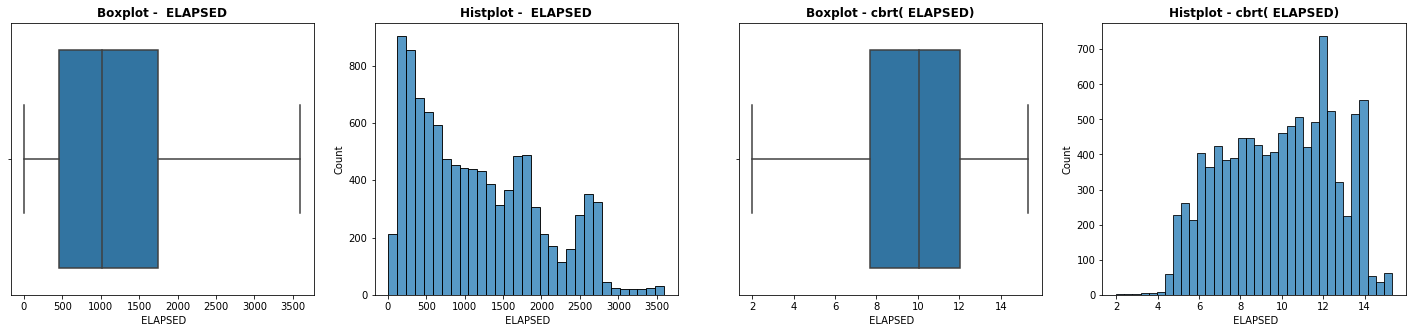

In [27]:
col = ' ELAPSED'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - cbrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - cbrt({col})", fontweight='bold');

In [28]:
train[' ELAPSED'] = np.cbrt(train[' ELAPSED'])
test[' ELAPSED'] = np.cbrt(test[' ELAPSED'])

#### HOUR

In [29]:
train[' HOUR'] = train[' HOUR'].map(seconder)
test[' HOUR'] = test[' HOUR'].map(seconder)
train[' HOUR'] = train[' HOUR'].astype('float')
test[' HOUR'] = test[' HOUR'].astype('float')

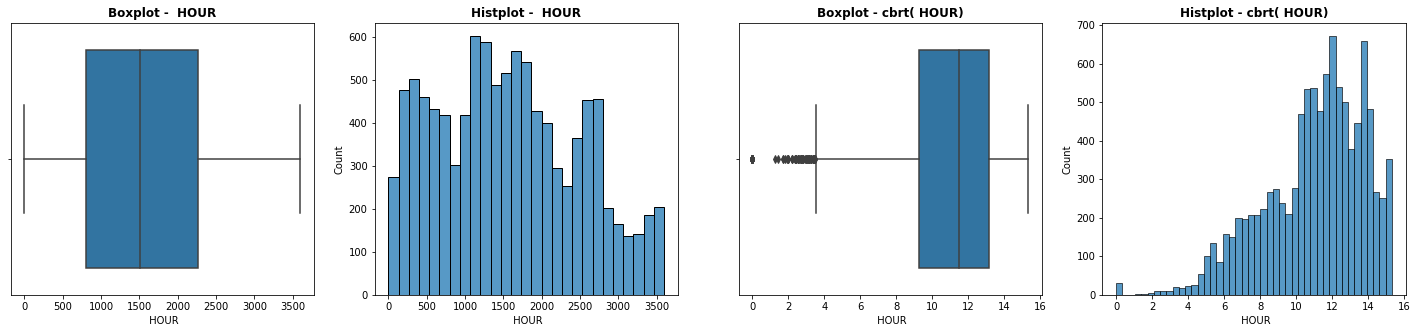

In [30]:
col = ' HOUR'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - cbrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - cbrt({col})", fontweight='bold');

#### S1_LARGE/S2_LARGE/S3_LARGE

In [31]:
train['S1_LARGE'] = train['S1_LARGE'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x))
test['S1_LARGE'] = test['S1_LARGE'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x))

train['S2_LARGE'] = train['S2_LARGE'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x))
test['S2_LARGE'] = test['S2_LARGE'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x))

train['S3_LARGE'] = train['S3_LARGE'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x))
test['S3_LARGE'] = test['S3_LARGE'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x))

train.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,92,0,1,343.003,0,35.427,0,...,343.003,35.004,43.003,SB,05:14.7,NaN,JR,NaN,Location 2,Free Practice 2
1,10,1,2,87,2,1,25.674,2,33.399,2,...,25.007,33.004,41.009,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
2,10,1,3,73,0,0,28.129,0,34.091,0,...,28.001,34.001,57.002,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
3,11,1,1,73,0,1,65.000,0,38.416,0,...,65.000,38.004,56.008,LGRA,00:33.0,NaN,AD,NaN,Location 2,Free Practice 2
4,11,1,2,73,0,1,28.013,0,36.743,0,...,28.000,36.007,44.007,LGRA,NaN,NaN,AD,NaN,Location 2,Free Practice 2


In [32]:
'''
s1_fill = train['S1_LARGE'].median()
s2_fill = train['S2_LARGE'].median()
s3_fill = train['S3_LARGE'].median()

train['S1_LARGE'].fillna(s1_fill, inplace=True)
train['S2_LARGE'].fillna(s2_fill, inplace=True)
train['S3_LARGE'].fillna(s3_fill, inplace=True)

test['S1_LARGE'].fillna(s1_fill, inplace=True)
test['S2_LARGE'].fillna(s2_fill, inplace=True)
test['S3_LARGE'].fillna(s3_fill, inplace=True)
'''

"\ns1_fill = train['S1_LARGE'].median()\ns2_fill = train['S2_LARGE'].median()\ns3_fill = train['S3_LARGE'].median()\n\ntrain['S1_LARGE'].fillna(s1_fill, inplace=True)\ntrain['S2_LARGE'].fillna(s2_fill, inplace=True)\ntrain['S3_LARGE'].fillna(s3_fill, inplace=True)\n\ntest['S1_LARGE'].fillna(s1_fill, inplace=True)\ntest['S2_LARGE'].fillna(s2_fill, inplace=True)\ntest['S3_LARGE'].fillna(s3_fill, inplace=True)\n"

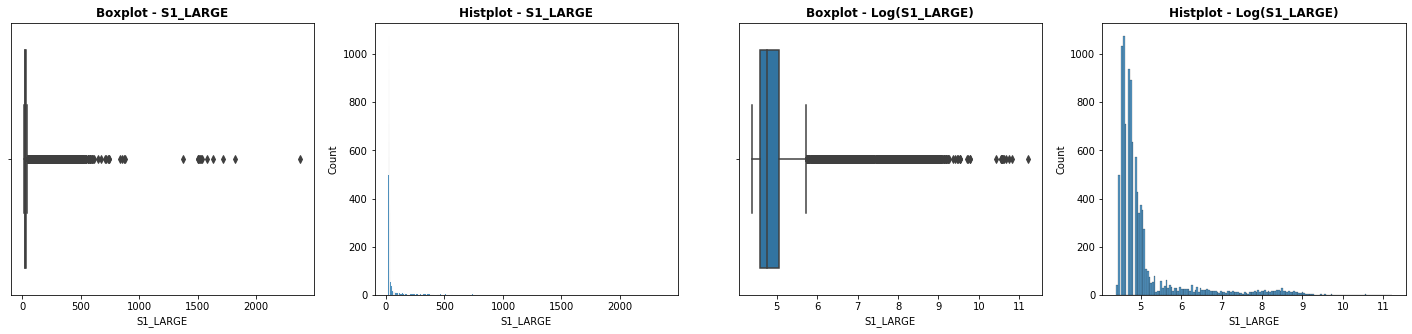

In [33]:
col = 'S1_LARGE'
x1 = train[col]
x2 = np.log2(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

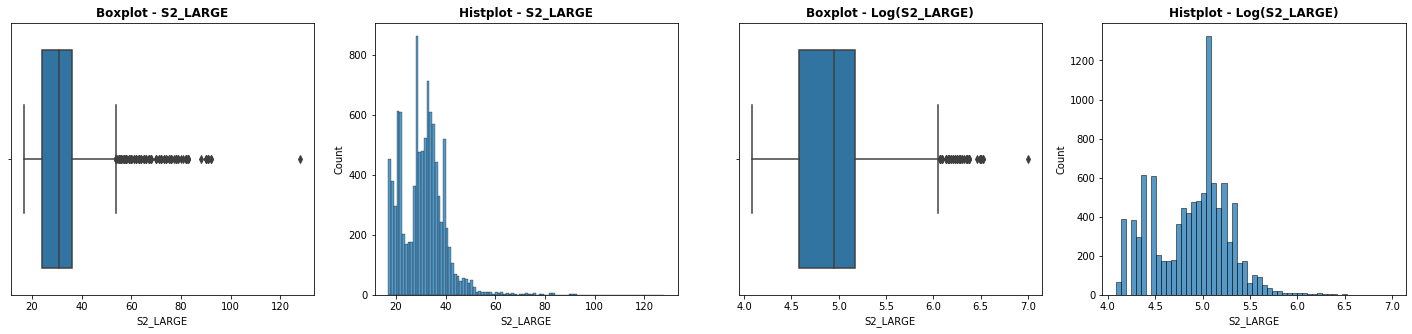

In [34]:
col = 'S2_LARGE'
x1 = train[col]
x2 = np.log2(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

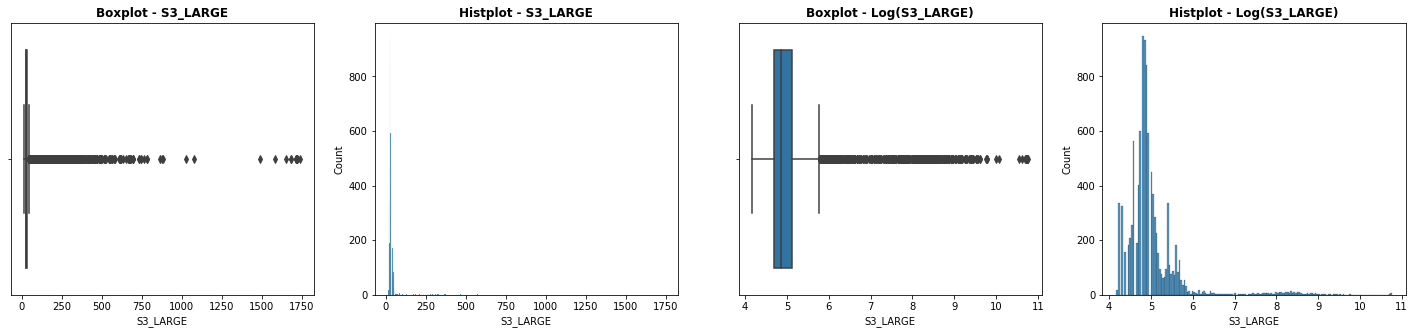

In [35]:
col = 'S3_LARGE'
x1 = train[col]
x2 = np.log2(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

In [36]:
'''
train['S1_LARGE'] = np.log2(train['S1_LARGE'])
train['S2_LARGE'] = np.log2(train['S2_LARGE'])
train['S3_LARGE'] = np.log2(train['S3_LARGE'])

test['S1_LARGE'] = np.log2(test['S1_LARGE'])
test['S2_LARGE'] = np.log2(test['S2_LARGE'])
test['S3_LARGE'] = np.log2(test['S3_LARGE'])
'''

"\ntrain['S1_LARGE'] = np.log2(train['S1_LARGE'])\ntrain['S2_LARGE'] = np.log2(train['S2_LARGE'])\ntrain['S3_LARGE'] = np.log2(train['S3_LARGE'])\n\ntest['S1_LARGE'] = np.log2(test['S1_LARGE'])\ntest['S2_LARGE'] = np.log2(test['S2_LARGE'])\ntest['S3_LARGE'] = np.log2(test['S3_LARGE'])\n"

#### DRIVER_NAME/TEAM

In [37]:
le = LabelEncoder().fit(train['DRIVER_NAME'].append(test['DRIVER_NAME']))
train['DRIVER_NAME'] = le.transform(train['DRIVER_NAME'])
test['DRIVER_NAME'] = le.transform(test['DRIVER_NAME'])
train.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,92,0,1,343.003,0,35.427,0,...,343.003,35.004,43.003,19,05:14.7,NaN,JR,NaN,Location 2,Free Practice 2
1,10,1,2,87,2,1,25.674,2,33.399,2,...,25.007,33.004,41.009,19,NaN,NaN,JR,NaN,Location 2,Free Practice 2
2,10,1,3,73,0,0,28.129,0,34.091,0,...,28.001,34.001,57.002,19,NaN,NaN,JR,NaN,Location 2,Free Practice 2
3,11,1,1,73,0,1,65.000,0,38.416,0,...,65.000,38.004,56.008,7,00:33.0,NaN,AD,NaN,Location 2,Free Practice 2
4,11,1,2,73,0,1,28.013,0,36.743,0,...,28.000,36.007,44.007,7,NaN,NaN,AD,NaN,Location 2,Free Practice 2


In [38]:
le = LabelEncoder().fit(train['TEAM'].append(test['TEAM']))
train['TEAM'] = le.transform(train['TEAM'])
test['TEAM'] = le.transform(test['TEAM'])
train.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,92,0,1,343.003,0,35.427,0,...,343.003,35.004,43.003,19,05:14.7,NaN,12,NaN,Location 2,Free Practice 2
1,10,1,2,87,2,1,25.674,2,33.399,2,...,25.007,33.004,41.009,19,NaN,NaN,12,NaN,Location 2,Free Practice 2
2,10,1,3,73,0,0,28.129,0,34.091,0,...,28.001,34.001,57.002,19,NaN,NaN,12,NaN,Location 2,Free Practice 2
3,11,1,1,73,0,1,65.000,0,38.416,0,...,65.000,38.004,56.008,7,00:33.0,NaN,0,NaN,Location 2,Free Practice 2
4,11,1,2,73,0,1,28.013,0,36.743,0,...,28.000,36.007,44.007,7,NaN,NaN,0,NaN,Location 2,Free Practice 2


#### PIT_TIME

In [39]:
train['PIT_TIME'] = train['PIT_TIME'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x))
test['PIT_TIME'] = test['PIT_TIME'].apply(lambda x: np.nan if pd.isnull(x) else seconder(x))
train.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,92,0,1,343.003,0,35.427,0,...,343.003,35.004,43.003,19,314.007,NaN,12,NaN,Location 2,Free Practice 2
1,10,1,2,87,2,1,25.674,2,33.399,2,...,25.007,33.004,41.009,19,NaN,NaN,12,NaN,Location 2,Free Practice 2
2,10,1,3,73,0,0,28.129,0,34.091,0,...,28.001,34.001,57.002,19,NaN,NaN,12,NaN,Location 2,Free Practice 2
3,11,1,1,73,0,1,65.000,0,38.416,0,...,65.000,38.004,56.008,7,33.000,NaN,0,NaN,Location 2,Free Practice 2
4,11,1,2,73,0,1,28.013,0,36.743,0,...,28.000,36.007,44.007,7,NaN,NaN,0,NaN,Location 2,Free Practice 2


In [40]:
'''
s1_fill = train['PIT_TIME'].median()
train['PIT_TIME'].fillna(s1_fill, inplace=True)
test['PIT_TIME'].fillna(s1_fill, inplace=True)
'''

"\ns1_fill = train['PIT_TIME'].median()\ntrain['PIT_TIME'].fillna(s1_fill, inplace=True)\ntest['PIT_TIME'].fillna(s1_fill, inplace=True)\n"

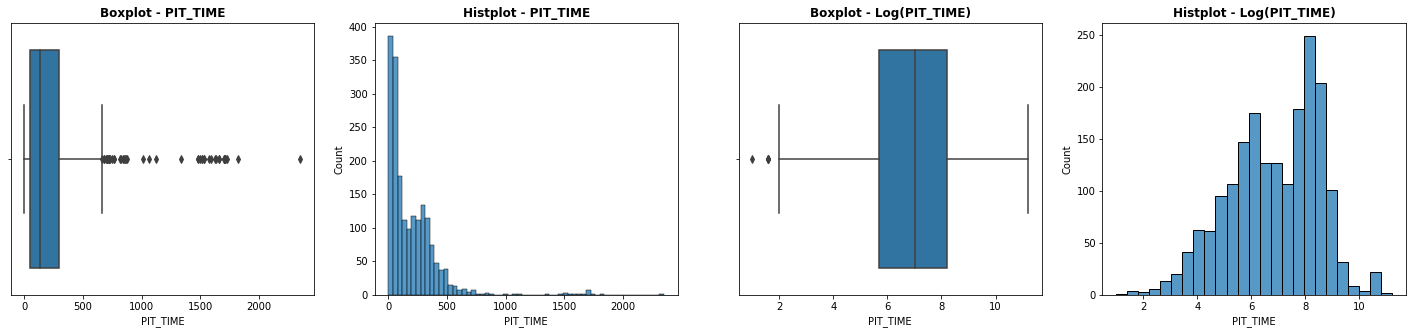

In [41]:
col = 'PIT_TIME'
x1 = train[col]
x2 = np.log2(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

In [42]:
'''
train['PIT_TIME'] = np.log2(train['PIT_TIME'])
test['PIT_TIME'] = np.log2(test['PIT_TIME'])
'''

"\ntrain['PIT_TIME'] = np.log2(train['PIT_TIME'])\ntest['PIT_TIME'] = np.log2(test['PIT_TIME'])\n"

#### GROUP

In [43]:
train['GROUP'].fillna(5, inplace=True)
test['GROUP'].fillna(5, inplace=True)

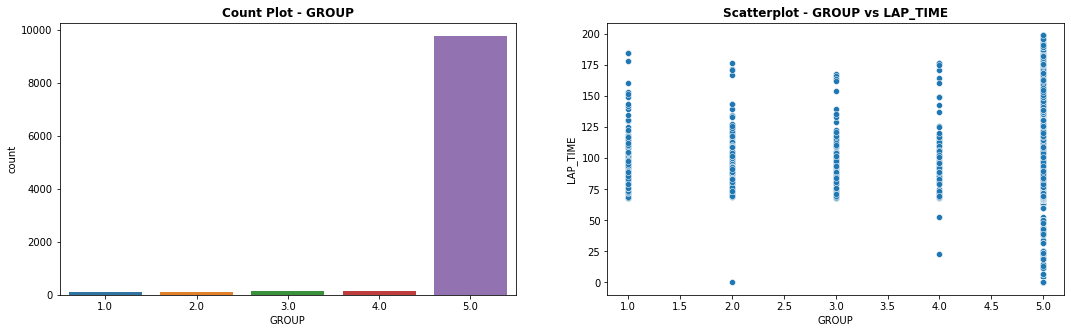

In [44]:
_, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.countplot(x='GROUP', data=train, ax=ax[0])
sns.scatterplot(x='GROUP', y='LAP_TIME', data=train, ax=ax[1])
ax[0].set_title('Count Plot - GROUP', fontweight='bold')
ax[1].set_title('Scatterplot - GROUP vs LAP_TIME', fontweight='bold');

#### POWER

In [45]:
train['POWER'].fillna(200, inplace=True)
test['POWER'].fillna(200, inplace=True)

#### LOCATION

In [46]:
train['LOCATION'] = train['LOCATION'].apply(lambda x: int(x[-1]))
test['LOCATION'] = test['LOCATION'].apply(lambda x: int(x[-1]))
train.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,92,0,1,343.003,0,35.427,0,...,343.003,35.004,43.003,19,314.007,5.0,12,200.0,2,Free Practice 2
1,10,1,2,87,2,1,25.674,2,33.399,2,...,25.007,33.004,41.009,19,NaN,5.0,12,200.0,2,Free Practice 2
2,10,1,3,73,0,0,28.129,0,34.091,0,...,28.001,34.001,57.002,19,NaN,5.0,12,200.0,2,Free Practice 2
3,11,1,1,73,0,1,65.000,0,38.416,0,...,65.000,38.004,56.008,7,33.000,5.0,0,200.0,2,Free Practice 2
4,11,1,2,73,0,1,28.013,0,36.743,0,...,28.000,36.007,44.007,7,NaN,5.0,0,200.0,2,Free Practice 2


#### EVENT

In [47]:
train['EVENT_TYPE'] = train['EVENT'].apply(lambda x: 1 if 'Free Practice' in x else 0)
test['EVENT_TYPE'] = test['EVENT'].apply(lambda x: 1 if 'Free Practice' in x else 0)

train['EVENT'] = train['EVENT'].apply(lambda x: int(x[-1]))
test['EVENT'] = test['EVENT'].apply(lambda x: int(x[-1]))
train.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT,EVENT_TYPE
0,10,1,1,92,0,1,343.003,0,35.427,0,...,35.004,43.003,19,314.007,5.0,12,200.0,2,2,1
1,10,1,2,87,2,1,25.674,2,33.399,2,...,33.004,41.009,19,NaN,5.0,12,200.0,2,2,1
2,10,1,3,73,0,0,28.129,0,34.091,0,...,34.001,57.002,19,NaN,5.0,12,200.0,2,2,1
3,11,1,1,73,0,1,65.000,0,38.416,0,...,38.004,56.008,7,33.000,5.0,0,200.0,2,2,1
4,11,1,2,73,0,1,28.013,0,36.743,0,...,36.007,44.007,7,NaN,5.0,0,200.0,2,2,1


In [48]:
train.drop([' DRIVER_NUMBER'], axis=1, inplace=True)
test.drop([' DRIVER_NUMBER','LAP_TIME'], axis=1, inplace=True)
print(f"train: {train.shape} \ntest: {test.shape}")

train: (10276, 25) 
test: (420, 24)


#### Extract target

In [49]:
train_y = train['LAP_TIME'].values
train.drop(['LAP_TIME'], axis=1, inplace=True)
train_y.shape

(10276,)

#### Fill NaN values

In [50]:
train = pd.DataFrame(mice(train.values), columns=train.columns, index=train.index)
train.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT,EVENT_TYPE
0,10.0,1.0,0.0,1.0,343.003,0.0,35.427,0.0,43.313,0.0,...,35.004,43.003,19.0,314.007000,5.0,12.0,200.0,2.0,2.0,1.0
1,10.0,2.0,2.0,1.0,25.674,2.0,33.399,2.0,41.922,2.0,...,33.004,41.009,19.0,344.087842,5.0,12.0,200.0,2.0,2.0,1.0
2,10.0,3.0,0.0,0.0,28.129,0.0,34.091,0.0,57.248,0.0,...,34.001,57.002,19.0,284.718208,5.0,12.0,200.0,2.0,2.0,1.0
3,11.0,1.0,0.0,1.0,65.000,0.0,38.416,0.0,56.833,0.0,...,38.004,56.008,7.0,33.000000,5.0,0.0,200.0,2.0,2.0,1.0
4,11.0,2.0,0.0,1.0,28.013,0.0,36.743,0.0,44.716,0.0,...,36.007,44.007,7.0,129.585945,5.0,0.0,200.0,2.0,2.0,1.0


In [51]:
test = pd.DataFrame(mice(test.values), columns=test.columns, index=test.index)
test.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT,EVENT_TYPE
0,10.0,1.0,0.0,1.0,70.002,0.0,35.433,0.0,30.693,0.0,...,35.004,30.007,19.0,47.000000,1.0,12.0,200.0,7.0,1.0,0.0
1,10.0,2.0,0.0,1.0,27.667,0.0,33.680,0.0,37.767,0.0,...,33.007,37.008,19.0,133.948628,1.0,12.0,250.0,7.0,1.0,0.0
2,10.0,3.0,2.0,1.0,24.688,2.0,29.309,2.0,27.111,2.0,...,29.003,27.001,19.0,178.027591,1.0,12.0,250.0,7.0,1.0,0.0
3,13.0,1.0,0.0,1.0,69.001,0.0,35.705,0.0,30.451,0.0,...,35.007,30.005,0.0,44.007000,1.0,7.0,200.0,7.0,1.0,0.0
4,13.0,2.0,0.0,1.0,28.401,0.0,33.693,0.0,35.958,0.0,...,33.007,36.000,0.0,131.653166,1.0,7.0,250.0,7.0,1.0,0.0


In [52]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10276 entries, 0 to 10275
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NUMBER                        10276 non-null  float64
 1    LAP_NUMBER                   10276 non-null  float64
 2    LAP_IMPROVEMENT              10276 non-null  float64
 3    CROSSING_FINISH_LINE_IN_PIT  10276 non-null  float64
 4    S1                           10276 non-null  float64
 5    S1_IMPROVEMENT               10276 non-null  float64
 6    S2                           10276 non-null  float64
 7    S2_IMPROVEMENT               10276 non-null  float64
 8    S3                           10276 non-null  float64
 9    S3_IMPROVEMENT               10276 non-null  float64
 10   KPH                          10276 non-null  float64
 11   ELAPSED                      10276 non-null  float64
 12   HOUR                         10276 non-null  float64
 13  S

## Data Preprocessing (Weather data)

In [53]:
def air_temp_prcs(x):
    tmp = x.replace(',','')
    if len(tmp) < 4:
        return float(tmp)/10.0
    elif len(tmp) >= 4 and len(tmp) < 6:
        return float(tmp) / 100.0
    elif len(tmp) >= 6 and len(tmp) < 10:
        return float(tmp) / 10000.0

In [54]:
def pressure_prcs(x):
    tmp = x.split(',')
    if len(tmp) < 3:
        return x.replace(',','.')
    else:
        return float(x.replace(',',''))/1000.0

In [55]:
def wind_speed_prcs(x):
    tmp = x.split(',')
    if len(tmp) < 3:
        return x.replace(',','.')
    else:
        return float(x.replace(',',''))/100000.0

In [56]:
train_weather['AIR_TEMP'] = train_weather['AIR_TEMP'].apply(lambda x: air_temp_prcs(x) if ',' in x else x)
train_weather['AIR_TEMP'] = train_weather['AIR_TEMP'].astype('float')

train_weather['PRESSURE'] = train_weather['PRESSURE'].apply(lambda x: pressure_prcs(x) if ',' in x else x)
train_weather['PRESSURE'] = train_weather['PRESSURE'].astype('float')

train_weather['WIND_SPEED'] = train_weather['WIND_SPEED'].apply(lambda x: wind_speed_prcs(x) if ',' in x else x)
train_weather['WIND_SPEED'] = train_weather['WIND_SPEED'].astype('float')

train_weather['TRACK_TEMP'] = train_weather['TRACK_TEMP'].apply(lambda x: float(x.replace(',','.')))
train_weather['HUMIDITY'] = train_weather['HUMIDITY'].apply(lambda x: float(x.replace(',','.')))
train_weather['RAIN'] = train_weather['RAIN'].apply(lambda x: float(x.replace(',','.')) if ',' in str(x) else x)
train_weather['RAIN'] = train_weather['RAIN'].astype('float')

In [57]:
df = train_weather.groupby(['LOCATION','EVENT']).agg({
    'AIR_TEMP': ['mean','std'],
    'TRACK_TEMP': ['mean','std'],
    'HUMIDITY': ['mean','std'],
    'PRESSURE': ['mean','std'],
    'WIND_SPEED': ['mean','std'],
    'WIND_DIRECTION': ['mean','std']
})

df.columns = ['_'.join(x) for x in df.columns]
df.reset_index(inplace=True)

df['LOCATION'] = df['LOCATION'].apply(lambda x: int(x[-1]))
df['EVENT_TYPE'] = df['EVENT'].apply(lambda x: 1 if 'Free Practice' in x else 0)
df['EVENT'] = df['EVENT'].apply(lambda x: int(x[-1]))
df.head()

,LOCATION,EVENT,AIR_TEMP_mean,AIR_TEMP_std,TRACK_TEMP_mean,TRACK_TEMP_std,HUMIDITY_mean,HUMIDITY_std,PRESSURE_mean,PRESSURE_std,WIND_SPEED_mean,WIND_SPEED_std,WIND_DIRECTION_mean,WIND_DIRECTION_std,EVENT_TYPE
0,1,1,17.538364,0.166663,19.564286,0.357376,45.000000,0.000000,937.023571,0.232658,4.723681,2.237762,306.476190,23.043160,1
1,1,2,20.851193,0.130115,34.039286,0.363460,34.321429,0.611832,937.238750,0.067931,3.523816,1.938146,293.357143,20.843712,1
2,1,3,22.498669,0.316774,34.259524,0.528717,30.595238,0.857094,937.191238,0.158998,3.081760,2.053611,234.571429,123.864234,1
3,1,1,22.277763,0.594636,28.625000,0.391882,31.500000,1.603567,937.200125,0.086964,2.387101,1.359844,265.375000,107.982720,0
4,1,2,22.349200,0.574394,27.714286,0.376070,31.714286,1.603567,937.144571,0.158262,1.818743,1.180499,221.714286,122.713371,0


In [58]:
train = pd.merge(
    train,
    df,
    how='left',
    on=['LOCATION','EVENT_TYPE','EVENT'],
    sort=False
)

train.fillna(-1, inplace=True)
train.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,TRACK_TEMP_mean,TRACK_TEMP_std,HUMIDITY_mean,HUMIDITY_std,PRESSURE_mean,PRESSURE_std,WIND_SPEED_mean,WIND_SPEED_std,WIND_DIRECTION_mean,WIND_DIRECTION_std
0,10.0,1.0,0.0,1.0,343.003,0.0,35.427,0.0,43.313,0.0,...,19.416216,0.801912,60.432432,0.502247,1018.215135,0.08614,3.584237,1.860442,148.0,23.558438
1,10.0,2.0,2.0,1.0,25.674,2.0,33.399,2.0,41.922,2.0,...,19.416216,0.801912,60.432432,0.502247,1018.215135,0.08614,3.584237,1.860442,148.0,23.558438
2,10.0,3.0,0.0,0.0,28.129,0.0,34.091,0.0,57.248,0.0,...,19.416216,0.801912,60.432432,0.502247,1018.215135,0.08614,3.584237,1.860442,148.0,23.558438
3,11.0,1.0,0.0,1.0,65.000,0.0,38.416,0.0,56.833,0.0,...,19.416216,0.801912,60.432432,0.502247,1018.215135,0.08614,3.584237,1.860442,148.0,23.558438
4,11.0,2.0,0.0,1.0,28.013,0.0,36.743,0.0,44.716,0.0,...,19.416216,0.801912,60.432432,0.502247,1018.215135,0.08614,3.584237,1.860442,148.0,23.558438


In [59]:
test = pd.merge(
    test,
    df,
    how='left',
    on=['LOCATION','EVENT_TYPE','EVENT'],
    sort=False
)

test.fillna(-1, inplace=True)
test.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,TRACK_TEMP_mean,TRACK_TEMP_std,HUMIDITY_mean,HUMIDITY_std,PRESSURE_mean,PRESSURE_std,WIND_SPEED_mean,WIND_SPEED_std,WIND_DIRECTION_mean,WIND_DIRECTION_std
0,10.0,1.0,0.0,1.0,70.002,0.0,35.433,0.0,30.693,0.0,...,18.4875,0.816679,82.58375,2.729359,1007.38625,0.696418,9.73375,5.979928,221.25,143.274711
1,10.0,2.0,0.0,1.0,27.667,0.0,33.680,0.0,37.767,0.0,...,18.4875,0.816679,82.58375,2.729359,1007.38625,0.696418,9.73375,5.979928,221.25,143.274711
2,10.0,3.0,2.0,1.0,24.688,2.0,29.309,2.0,27.111,2.0,...,18.4875,0.816679,82.58375,2.729359,1007.38625,0.696418,9.73375,5.979928,221.25,143.274711
3,13.0,1.0,0.0,1.0,69.001,0.0,35.705,0.0,30.451,0.0,...,18.4875,0.816679,82.58375,2.729359,1007.38625,0.696418,9.73375,5.979928,221.25,143.274711
4,13.0,2.0,0.0,1.0,28.401,0.0,33.693,0.0,35.958,0.0,...,18.4875,0.816679,82.58375,2.729359,1007.38625,0.696418,9.73375,5.979928,221.25,143.274711


In [60]:
train[train.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,TRACK_TEMP_mean,TRACK_TEMP_std,HUMIDITY_mean,HUMIDITY_std,PRESSURE_mean,PRESSURE_std,WIND_SPEED_mean,WIND_SPEED_std,WIND_DIRECTION_mean,WIND_DIRECTION_std


In [61]:
test[test.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,TRACK_TEMP_mean,TRACK_TEMP_std,HUMIDITY_mean,HUMIDITY_std,PRESSURE_mean,PRESSURE_std,WIND_SPEED_mean,WIND_SPEED_std,WIND_DIRECTION_mean,WIND_DIRECTION_std


In [62]:
train['LAP_TIME'] = train_y.ravel()
train.shape

(10276, 37)

## Features Correlation

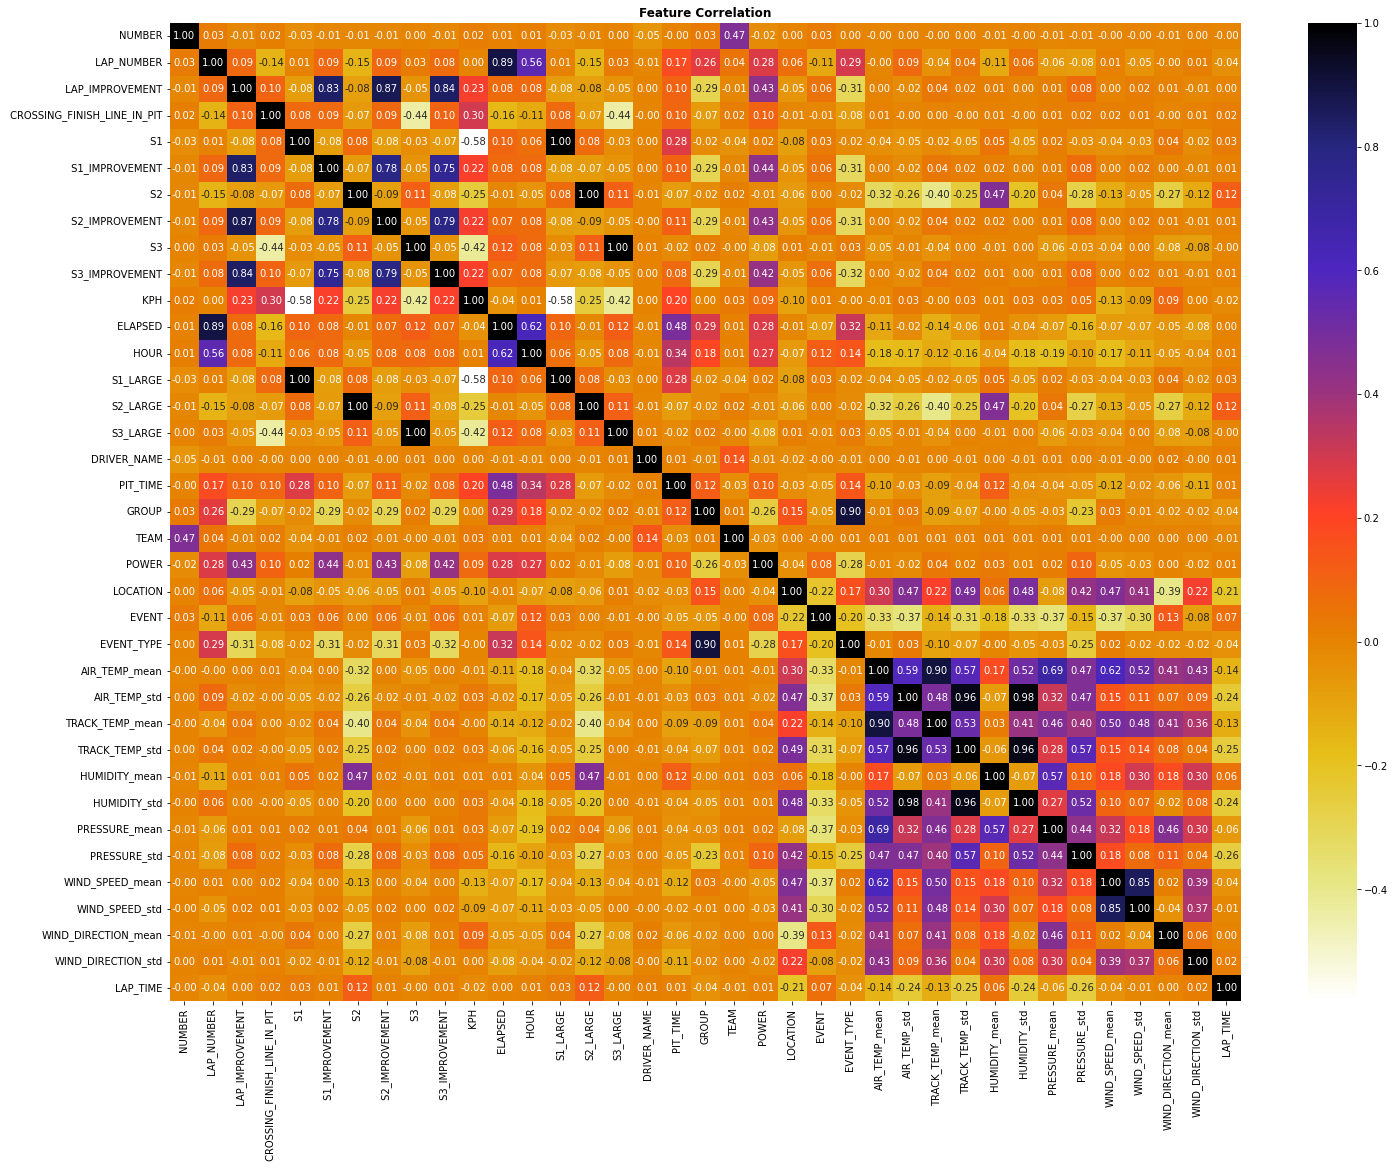

In [63]:
plt.subplots(1,1,figsize=(24, 18))
sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap="CMRmap_r")
plt.title("Feature Correlation", fontweight='bold');

## Feature Engineering

In [64]:
train['Mean_S'] = (train[' S1'] + train[' S2'] + train[' S3'])/3.0
train['Mean_S_Large'] = (train['S1_LARGE'] + train['S2_LARGE'] + train['S3_LARGE'])/3.0
train['S1_Large_Ratio'] = train[' S1']/train['S1_LARGE']
train['S2_Large_Ratio'] = train[' S2']/train['S2_LARGE']
train['S3_Large_Ratio'] = train[' S3']/train['S3_LARGE']

In [65]:
temp = train.groupby([' S1_IMPROVEMENT']).agg({
    ' S1': ['mean','std'], 
    ' S2': ['mean','std'], 
    ' S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s1_imp_'+'_'.join(x) for x in temp.columns]
train = pd.merge(train, temp, on=[' S1_IMPROVEMENT'], how='left', sort=False)

del temp
gc.collect()

train.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,s1_imp_ S2_mean,s1_imp_ S2_std,s1_imp_ S3_mean,s1_imp_ S3_std,s1_imp_S1_LARGE_mean,s1_imp_S1_LARGE_std,s1_imp_S2_LARGE_mean,s1_imp_S2_LARGE_std,s1_imp_S3_LARGE_mean,s1_imp_S3_LARGE_std
0,10.0,1.0,0.0,1.0,343.003,0.0,35.427,0.0,43.313,0.0,...,31.549991,8.805815,45.727003,89.372331,53.293176,96.848027,31.112558,8.828572,45.313709,89.438585
1,10.0,2.0,2.0,1.0,25.674,2.0,33.399,2.0,41.922,2.0,...,28.949321,7.069289,29.532365,10.300285,25.361874,2.901735,28.516790,7.061945,29.061003,10.330448
2,10.0,3.0,0.0,0.0,28.129,0.0,34.091,0.0,57.248,0.0,...,31.549991,8.805815,45.727003,89.372331,53.293176,96.848027,31.112558,8.828572,45.313709,89.438585
3,11.0,1.0,0.0,1.0,65.000,0.0,38.416,0.0,56.833,0.0,...,31.549991,8.805815,45.727003,89.372331,53.293176,96.848027,31.112558,8.828572,45.313709,89.438585
4,11.0,2.0,0.0,1.0,28.013,0.0,36.743,0.0,44.716,0.0,...,31.549991,8.805815,45.727003,89.372331,53.293176,96.848027,31.112558,8.828572,45.313709,89.438585


In [66]:
temp = train.groupby([' S2_IMPROVEMENT']).agg({
    ' S1': ['mean','std'], 
    ' S2': ['mean','std'], 
    ' S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s2_imp_'+'_'.join(x) for x in temp.columns]
train = pd.merge(train, temp, on=[' S2_IMPROVEMENT'], how='left', sort=False)

del temp
gc.collect()

train.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,s2_imp_ S2_mean,s2_imp_ S2_std,s2_imp_ S3_mean,s2_imp_ S3_std,s2_imp_S1_LARGE_mean,s2_imp_S1_LARGE_std,s2_imp_S2_LARGE_mean,s2_imp_S2_LARGE_std,s2_imp_S3_LARGE_mean,s2_imp_S3_LARGE_std
0,10.0,1.0,0.0,1.0,343.003,0.0,35.427,0.0,43.313,0.0,...,31.577939,8.822560,45.784239,89.446350,53.298168,96.884554,31.140691,8.845734,45.370282,89.512886
1,10.0,2.0,2.0,1.0,25.674,2.0,33.399,2.0,41.922,2.0,...,28.636898,6.715402,29.214719,8.452529,25.637802,6.256729,28.202076,6.696232,28.752520,8.478809
2,10.0,3.0,0.0,0.0,28.129,0.0,34.091,0.0,57.248,0.0,...,31.577939,8.822560,45.784239,89.446350,53.298168,96.884554,31.140691,8.845734,45.370282,89.512886
3,11.0,1.0,0.0,1.0,65.000,0.0,38.416,0.0,56.833,0.0,...,31.577939,8.822560,45.784239,89.446350,53.298168,96.884554,31.140691,8.845734,45.370282,89.512886
4,11.0,2.0,0.0,1.0,28.013,0.0,36.743,0.0,44.716,0.0,...,31.577939,8.822560,45.784239,89.446350,53.298168,96.884554,31.140691,8.845734,45.370282,89.512886


In [67]:
temp = train.groupby([' S3_IMPROVEMENT']).agg({
    ' S1': ['mean','std'], 
    ' S2': ['mean','std'], 
    ' S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s3_imp_'+'_'.join(x) for x in temp.columns]
train = pd.merge(train, temp, on=[' S3_IMPROVEMENT'], how='left', sort=False)

del temp
gc.collect()

train.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,s3_imp_ S2_mean,s3_imp_ S2_std,s3_imp_ S3_mean,s3_imp_ S3_std,s3_imp_S1_LARGE_mean,s3_imp_S1_LARGE_std,s3_imp_S2_LARGE_mean,s3_imp_S2_LARGE_std,s3_imp_S3_LARGE_mean,s3_imp_S3_LARGE_std
0,10.0,1.0,0.0,1.0,343.003,0.0,35.427,0.0,43.313,0.0,...,31.565610,8.818134,45.818327,89.463259,53.102187,95.711980,31.128861,8.841182,45.405103,89.529693
1,10.0,2.0,2.0,1.0,25.674,2.0,33.399,2.0,41.922,2.0,...,28.786229,6.861554,28.853553,7.053677,28.437437,57.632564,28.336917,6.845247,28.385991,7.075879
2,10.0,3.0,0.0,0.0,28.129,0.0,34.091,0.0,57.248,0.0,...,31.565610,8.818134,45.818327,89.463259,53.102187,95.711980,31.128861,8.841182,45.405103,89.529693
3,11.0,1.0,0.0,1.0,65.000,0.0,38.416,0.0,56.833,0.0,...,31.565610,8.818134,45.818327,89.463259,53.102187,95.711980,31.128861,8.841182,45.405103,89.529693
4,11.0,2.0,0.0,1.0,28.013,0.0,36.743,0.0,44.716,0.0,...,31.565610,8.818134,45.818327,89.463259,53.102187,95.711980,31.128861,8.841182,45.405103,89.529693


In [68]:
test['Mean_S'] = (test[' S1'] + test[' S2'] + test[' S3'])/3.0
test['Mean_S_Large'] = (test['S1_LARGE'] + test['S2_LARGE'] + test['S3_LARGE'])/3.0
test['S1_Large_Ratio'] = test[' S1']/test['S1_LARGE']
test['S2_Large_Ratio'] = test[' S2']/test['S2_LARGE']
test['S3_Large_Ratio'] = test[' S3']/test['S3_LARGE']

In [69]:
temp = test.groupby([' S1_IMPROVEMENT']).agg({
    ' S1': ['mean','std'], 
    ' S2': ['mean','std'], 
    ' S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s1_imp_'+'_'.join(x) for x in temp.columns]
test = pd.merge(test, temp, on=[' S1_IMPROVEMENT'], how='left', sort=False)

del temp
gc.collect()

test.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,s1_imp_ S2_mean,s1_imp_ S2_std,s1_imp_ S3_mean,s1_imp_ S3_std,s1_imp_S1_LARGE_mean,s1_imp_S1_LARGE_std,s1_imp_S2_LARGE_mean,s1_imp_S2_LARGE_std,s1_imp_S3_LARGE_mean,s1_imp_S3_LARGE_std
0,10.0,1.0,0.0,1.0,70.002,0.0,35.433,0.0,30.693,0.0,...,31.830646,5.169607,30.934818,31.676091,70.036903,72.828165,31.387209,5.22063,30.489835,31.730387
1,10.0,2.0,0.0,1.0,27.667,0.0,33.680,0.0,37.767,0.0,...,31.830646,5.169607,30.934818,31.676091,70.036903,72.828165,31.387209,5.22063,30.489835,31.730387
2,10.0,3.0,2.0,1.0,24.688,2.0,29.309,2.0,27.111,2.0,...,26.231630,4.181897,28.761345,37.883767,23.382790,0.919738,25.802664,4.18930,28.290597,37.948689
3,13.0,1.0,0.0,1.0,69.001,0.0,35.705,0.0,30.451,0.0,...,31.830646,5.169607,30.934818,31.676091,70.036903,72.828165,31.387209,5.22063,30.489835,31.730387
4,13.0,2.0,0.0,1.0,28.401,0.0,33.693,0.0,35.958,0.0,...,31.830646,5.169607,30.934818,31.676091,70.036903,72.828165,31.387209,5.22063,30.489835,31.730387


In [70]:
temp = test.groupby([' S2_IMPROVEMENT']).agg({
    ' S1': ['mean','std'], 
    ' S2': ['mean','std'], 
    ' S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s2_imp_'+'_'.join(x) for x in temp.columns]
test = pd.merge(test, temp, on=[' S2_IMPROVEMENT'], how='left', sort=False)

del temp
gc.collect()

test.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,s2_imp_ S2_mean,s2_imp_ S2_std,s2_imp_ S3_mean,s2_imp_ S3_std,s2_imp_S1_LARGE_mean,s2_imp_S1_LARGE_std,s2_imp_S2_LARGE_mean,s2_imp_S2_LARGE_std,s2_imp_S3_LARGE_mean,s2_imp_S3_LARGE_std
0,10.0,1.0,0.0,1.0,70.002,0.0,35.433,0.0,30.693,0.0,...,31.962791,5.282603,33.266573,39.816346,69.867253,72.878389,31.520769,5.335158,32.826848,39.884875
1,10.0,2.0,0.0,1.0,27.667,0.0,33.680,0.0,37.767,0.0,...,31.962791,5.282603,33.266573,39.816346,69.867253,72.878389,31.520769,5.335158,32.826848,39.884875
2,10.0,3.0,2.0,1.0,24.688,2.0,29.309,2.0,27.111,2.0,...,26.099748,3.978793,23.608958,4.488608,23.777555,4.545801,25.668244,3.998114,23.127994,4.485774
3,13.0,1.0,0.0,1.0,69.001,0.0,35.705,0.0,30.451,0.0,...,31.962791,5.282603,33.266573,39.816346,69.867253,72.878389,31.520769,5.335158,32.826848,39.884875
4,13.0,2.0,0.0,1.0,28.401,0.0,33.693,0.0,35.958,0.0,...,31.962791,5.282603,33.266573,39.816346,69.867253,72.878389,31.520769,5.335158,32.826848,39.884875


In [71]:
temp = test.groupby([' S3_IMPROVEMENT']).agg({
    ' S1': ['mean','std'], 
    ' S2': ['mean','std'], 
    ' S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s3_imp_'+'_'.join(x) for x in temp.columns]
test = pd.merge(test, temp, on=[' S3_IMPROVEMENT'], how='left', sort=False)

del temp
gc.collect()

test.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,s3_imp_ S2_mean,s3_imp_ S2_std,s3_imp_ S3_mean,s3_imp_ S3_std,s3_imp_S1_LARGE_mean,s3_imp_S1_LARGE_std,s3_imp_S2_LARGE_mean,s3_imp_S2_LARGE_std,s3_imp_S3_LARGE_mean,s3_imp_S3_LARGE_std
0,10.0,1.0,0.0,1.0,70.002,0.0,35.433,0.0,30.693,0.0,...,31.960043,5.293034,33.397839,39.898856,69.935554,72.940994,31.519004,5.345454,32.958994,39.968301
1,10.0,2.0,0.0,1.0,27.667,0.0,33.680,0.0,37.767,0.0,...,31.960043,5.293034,33.397839,39.898856,69.935554,72.940994,31.519004,5.345454,32.958994,39.968301
2,10.0,3.0,2.0,1.0,24.688,2.0,29.309,2.0,27.111,2.0,...,26.173042,3.984484,23.423521,3.609149,24.012899,6.898306,25.727210,4.012096,22.929361,3.566081
3,13.0,1.0,0.0,1.0,69.001,0.0,35.705,0.0,30.451,0.0,...,31.960043,5.293034,33.397839,39.898856,69.935554,72.940994,31.519004,5.345454,32.958994,39.968301
4,13.0,2.0,0.0,1.0,28.401,0.0,33.693,0.0,35.958,0.0,...,31.960043,5.293034,33.397839,39.898856,69.935554,72.940994,31.519004,5.345454,32.958994,39.968301


## Feature Scaling

In [72]:
cat_cols = ['NUMBER',' LAP_NUMBER',' LAP_IMPROVEMENT',' CROSSING_FINISH_LINE_IN_PIT',
            ' S1_IMPROVEMENT',' S2_IMPROVEMENT',' S3_IMPROVEMENT','DRIVER_NAME',
            'GROUP','TEAM','POWER','LOCATION','EVENT','EVENT_TYPE']

num_cols = [col for col in test.columns if col not in cat_cols]

In [73]:
scaler = MinMaxScaler().fit(train[num_cols])
train[num_cols] = scaler.transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

In [74]:
Xtrain = train.loc[:, ~train.columns.isin(['LAP_TIME'])].copy()
Ytrain = train['LAP_TIME'].copy()
Ytrain_strat = pd.qcut(train['LAP_TIME'], q=15, labels=range(15))
Xtest = test.copy()

print("Xtrain: {} \nYtrain: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape))

del train
del test
gc.collect()

Xtrain: (10276, 77) 
Ytrain: (10276,) 
Xtest: (420, 77)


21

## Keras DNN Model

In [75]:
def dnn_model(cat_features, num_features):
    
    cat_input = Input(shape=(cat_features,))
    num_input = Input(shape=(num_features,))
    
    embed = Embedding(256, 8)(cat_input)
    
    x1 = Conv1D(filters=12, kernel_size=3, 
                strides=1, padding='same', 
                kernel_regularizer=l2(0.0003),
                kernel_initializer='lecun_normal')(embed)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    x1 = Activation('relu')(x1)
    x1 = AveragePooling1D()(x1)
    
    x2 = Conv1D(filters=16, kernel_size=3, 
                strides=1, padding='same', 
                kernel_regularizer=l2(0.0003),
                kernel_initializer='lecun_normal')(x1)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    x2 = Activation('relu')(x2)
    
    x3 = Conv1D(filters=16, kernel_size=3, 
                strides=1, padding='same', 
                kernel_regularizer=l2(0.0003),
                kernel_initializer='lecun_normal')(embed)
    x3 = LayerNormalization(epsilon=1e-5)(x3)
    x3 = Activation('relu')(x3)
    x3 = AveragePooling1D()(x3)
    
    x = Concatenate(axis=1)([x2, x3])
    x = Flatten()(x)
    
    c = Concatenate()([x, num_input])
    c = LayerNormalization(epsilon=1e-5)(c)
    
    x1 = Dense(units=128, kernel_initializer='lecun_normal', 
               kernel_regularizer=l2(0.0001))(c)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    x1 = Activation('relu')(x1)
    x2 = Dropout(rate=0.35)(x1)
    
    x2 = Dense(units=64, kernel_initializer='lecun_normal', 
               kernel_regularizer=l2(0.0001))(x2)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    x2 = Activation('relu')(x2)
    
    x = Concatenate()([c, x1, x2])
    x = LayerNormalization(epsilon=1e-5)(x)
    x = Dropout(rate=0.25)(x)
    
    x = Dense(units=32, kernel_initializer='lecun_normal', 
              kernel_regularizer=l2(0.0001))(x)
    x = LayerNormalization(epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.15)(x)

    x_output = Dense(units=1, kernel_initializer='lecun_normal')(x)

    model = Model(inputs=[cat_input, num_input], outputs=x_output, 
                  name='DNN_Model')
    return model

In [76]:
model = dnn_model(len(cat_cols), len(num_cols))
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 14, 8)        2048        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 14, 12)       300         embedding[0][0]                  
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 14, 12)       24          conv1d[0][0]                     
__________________________________________________________________________________________

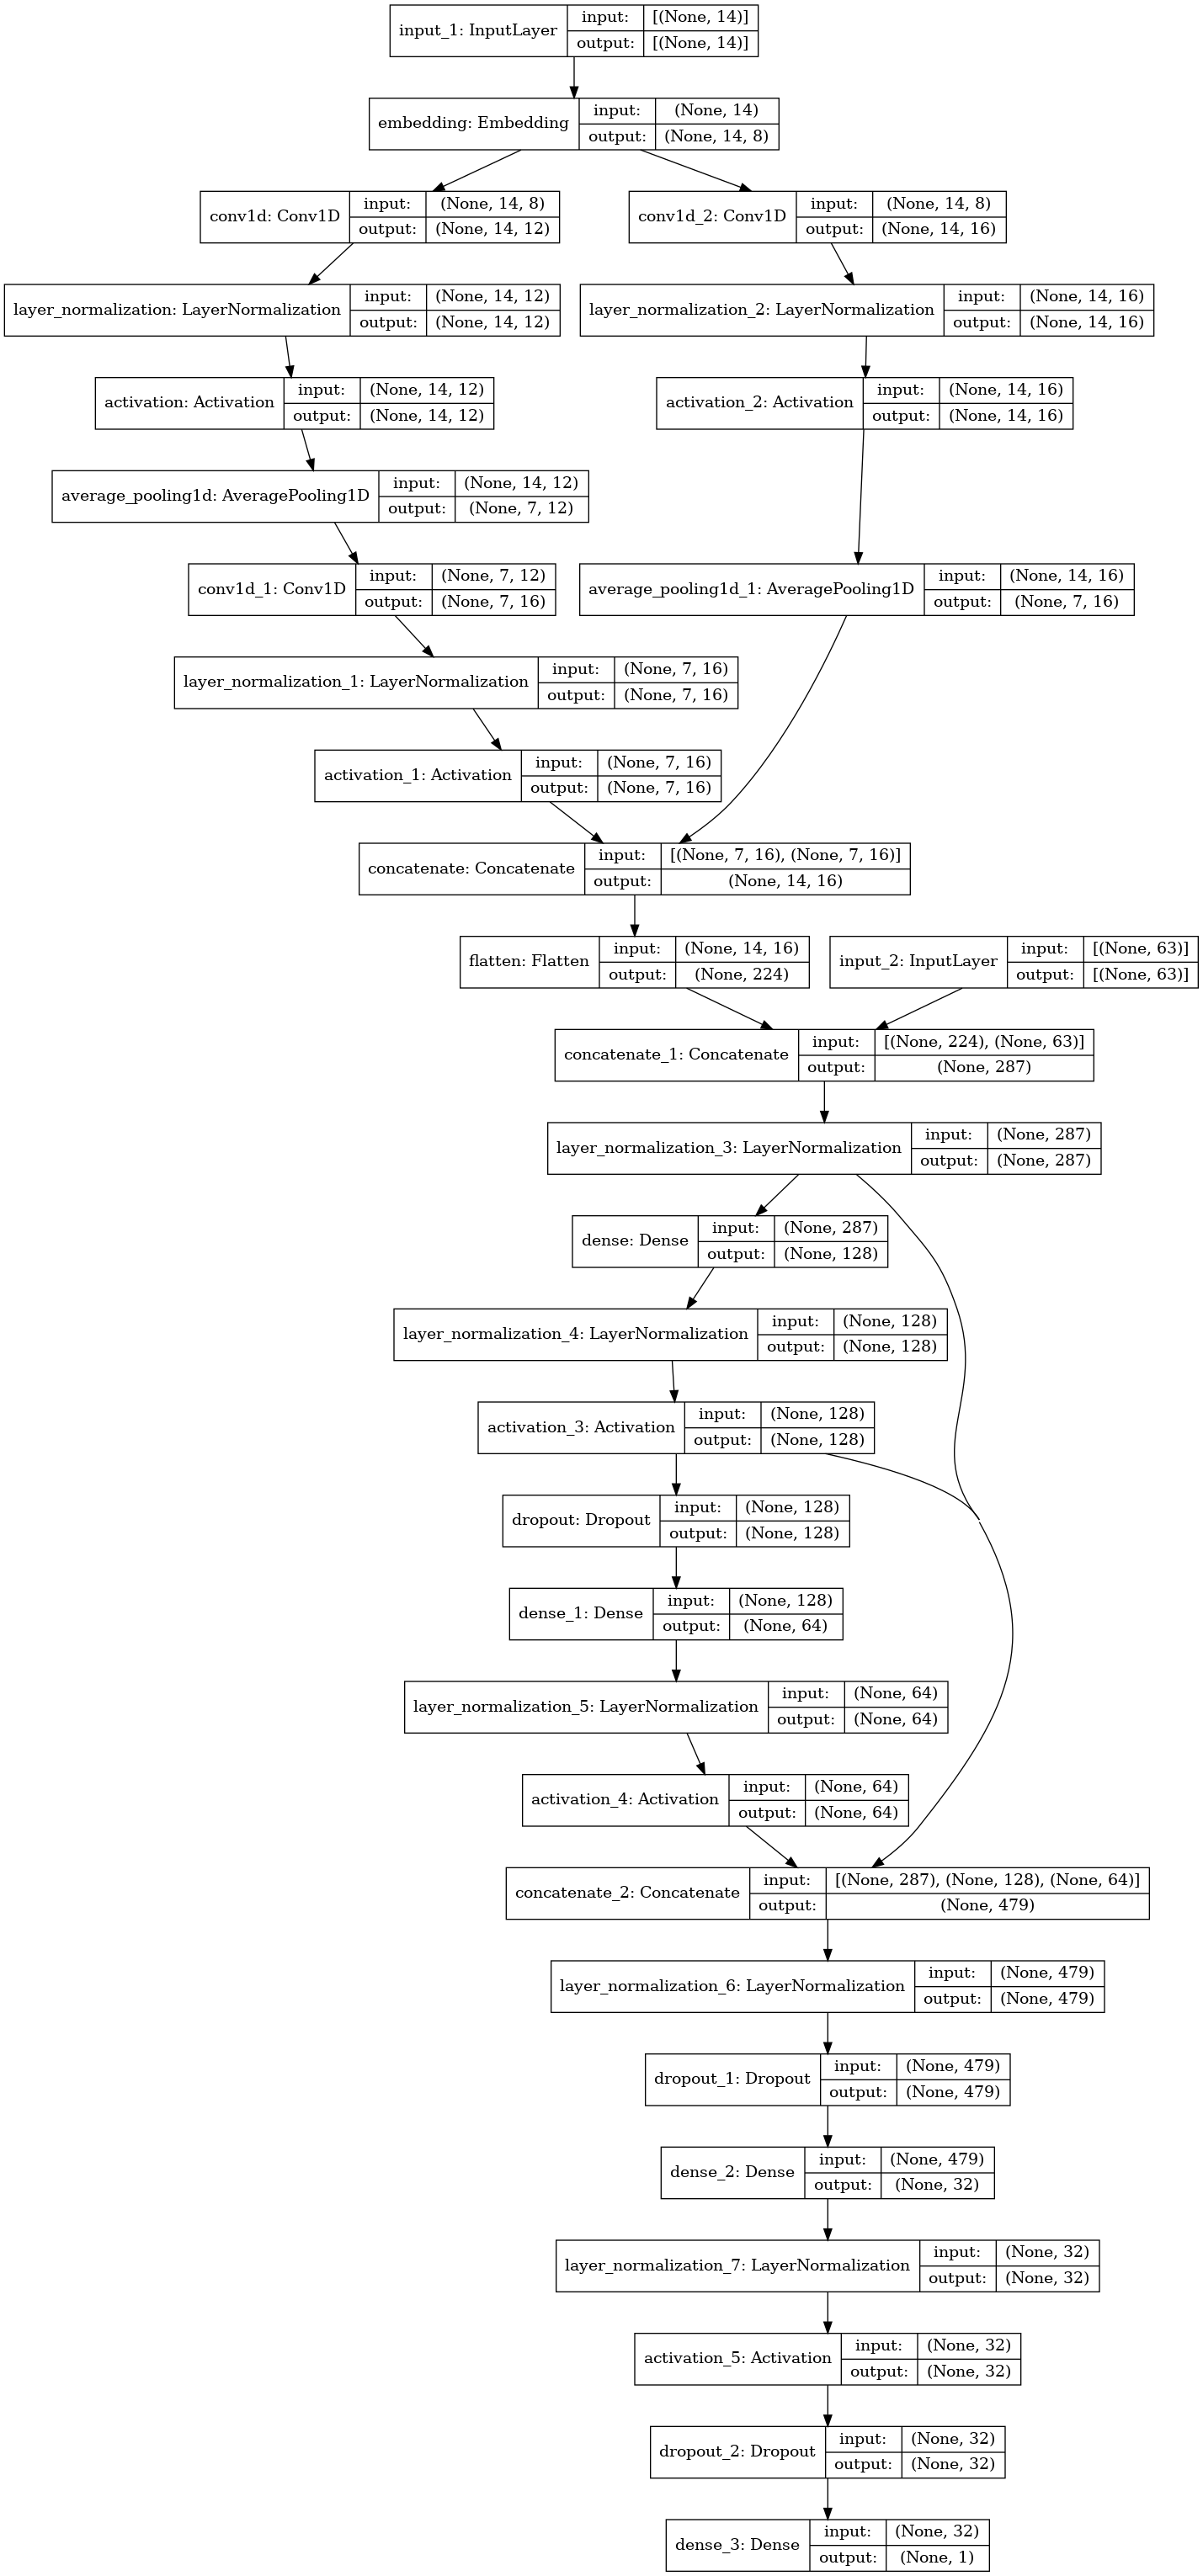

In [77]:
plot_model(
    model, 
    to_file='DareInReality_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [78]:
FOLD = 5
VERBOSE = 0
BATCH_SIZE = 128
SEEDS = [2021, 2011]

counter = 0
oof_score = 0
y_pred_meta_dnn = np.zeros((Xtrain.shape[0], len(SEEDS)))
y_pred_final_dnn = np.zeros((Xtest.shape[0], len(SEEDS)))


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain_strat)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = dnn_model(len(cat_cols), len(num_cols))
        model.compile(loss='mse', metrics=['msle'],
                      optimizer=Adam(learning_rate=1e-2))

        early = EarlyStopping(monitor="val_msle", mode="min", 
                              restore_best_weights=True, 
                              patience=18, verbose=VERBOSE)

        reduce_lr = ReduceLROnPlateau(monitor="val_msle", factor=0.25, 
                                      min_lr=1e-5, patience=4, 
                                      verbose=VERBOSE, mode='min')

        chk_point = ModelCheckpoint('./DNN_model.h5', 
                                    monitor='val_msle', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')
        
        history = model.fit(
            [train_x[cat_cols], train_x[num_cols]], train_y, 
            batch_size=BATCH_SIZE,
            epochs=100, 
            verbose=VERBOSE, 
            callbacks=[reduce_lr, early, chk_point], 
            validation_data=([val_x[cat_cols], val_x[num_cols]], val_y)
        )
        
        model = load_model('./DNN_model.h5')

        y_pred = model.predict([val_x[cat_cols], val_x[num_cols]], batch_size=BATCH_SIZE)
        y_pred_meta_dnn[val, sidx] += y_pred.ravel()
        y_pred_final_dnn[:, sidx] += model.predict([Xtest[cat_cols], Xtest[num_cols]], batch_size=BATCH_SIZE).ravel()
        
        score = np.sqrt(mean_squared_log_error(val_y, y_pred))
        oof_score += score
        seed_score += score
        print("\nSeed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx+1, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_final_dnn = y_pred_final_dnn / float(FOLD)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

2021-11-21 11:41:04.235821: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



Seed-2021 | Fold-1 | OOF Score: 0.553264751274838


Seed-2021 | Fold-2 | OOF Score: 0.5657584086215908


Seed-2021 | Fold-3 | OOF Score: 0.5324665111772346


Seed-2021 | Fold-4 | OOF Score: 0.5988736470630228


Seed-2021 | Fold-5 | OOF Score: 0.5336224714156577


Seed: 2021 | Aggregate OOF Score: 0.5567971579104688



Seed-2011 | Fold-1 | OOF Score: 0.5307333866908535


Seed-2011 | Fold-2 | OOF Score: 0.5962851168498124


Seed-2011 | Fold-3 | OOF Score: 0.6136940071841582


Seed-2011 | Fold-4 | OOF Score: 0.5515108485712306


Seed-2011 | Fold-5 | OOF Score: 0.47355409391091313


Seed: 2011 | Aggregate OOF Score: 0.5531554906413936


Aggregate OOF Score: 0.5549763242759311


In [79]:
np.savez_compressed('./Meta_Features.npz',
                    y_pred_meta_dnn=y_pred_meta_dnn,
                    y_pred_final_dnn=y_pred_final_dnn)

## Create submission file

In [80]:
submit_df = pd.DataFrame()
submit_df['LAP_TIME'] = np.mean(y_pred_final_dnn, axis=1)
submit_df.to_csv("./submission.csv", index=False)
submit_df.head()

,LAP_TIME
0,94.738111
1,94.816663
2,94.729400
3,94.813625
4,94.813349
